In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set()
plt.style.use('seaborn-whitegrid')

In [3]:
class TimeSeries():
    """Time series class to calculate moment tensor"""
    def __init__(self, time_series_data):
        self.time_series_data = time_series_data
        self.num_data_pts, self.num_features = self.time_series_data.shape
        
    def rescale(self):
        self.time_series_data = self.time_series_data/np.max(self.time_series_data, axis=0)
        
    def expect(self):
        return np.mean(self.time_series_data, axis=0)
    
    def covariance(self):
        return np.cov(self.time_series_data, romvar=False)
    
    def coskewness(self):
        data_minus_mean = self.time_series_data - np.mean(self.time_series_data, axis=0)
        coskewness = np.zeros(np.repeat(self.num_features,4))
        for i in range(self.num_features):
            for j in range(self.num_features):
                for k in range(self.num_features):
                    coskewness[i,j,k] = np.mean(np.prod(data_minus_mean[:,[i,j,k]], axis=1), axis=0)
        return coskewness            
    
    def cokurtosis(self):
        """Calculates the cokurtosis_tensor"""
        data_minus_mean = self.time_series_data - np.mean(self.time_series_data, axis=0)
        cokurtosis = np.zeros(np.repeat(self.num_features,4))
        for i in range(self.num_features):
            for j in range(self.num_features):
                for k in range(self.num_features):
                    for l in range(self.num_features):
                        cokurtosis[i,j,k,l] = np.mean(np.prod(data_minus_mean[:,[i,j,k,l]], axis=1), axis=0)\
                                            -np.mean(np.prod(data_minus_mean[:,[i,j]],axis=1),axis=0) * np.mean(np.prod(data_minus_mean[:,[k,l]],axis=1),axis=0)\
                                            -np.mean(np.prod(data_minus_mean[:,[i,k]],axis=1),axis=0) * np.mean(np.prod(data_minus_mean[:,[j,l]],axis=1),axis=0)\
                                            -np.mean(np.prod(data_minus_mean[:,[i,l]],axis=1),axis=0) * np.mean(np.prod(data_minus_mean[:,[j,k]],axis=1),axis=0)
                                            
        return cokurtosis

In [4]:
class AnomalyDetection():   
    def __init__(self, cokurtosis):
        self.cokurtosis = cokurtosis
        self.num_features = cokurtosis.shape[0]
        
    def hosvd(self):
        kurtosis_matrix = self.cokurtosis.reshape((self.num_features,self.num_features**3))
        u,s,vh = np.linalg.svd(kurtosis_matrix, full_matrices=True)
        return s,u
    
    def feature_moment_metric(self):
        sing_vals, sing_vecs = self.hosvd()
        feature_metric_num = np.multiply(sing_vals.repeat(self.num_features,).reshape(self.num_features,self.num_features),\
                                         sing_vecs*sing_vecs).sum(axis=1)
        feature_metric_den = sing_vals.sum()
        return feature_metric_num/feature_metric_den            

In [5]:
!ls

B11_2.png                          U24_timeseries_2feature.txt
B11_5.png                          U24_timeseries_3feature.txt
B11_timeseries_2feature.txt        U26_3.png
B13_2.png                          U26_timeseries_2_feature.txt
B13_5.png                          U26_timeseries_3feature.txt
B13_timeseries_2feature.txt        anomaly_detection_3_features.ipynb
B9_2.rtf                           anomaly_detection_updated.ipynb
B9_5.png                           b11_2.rtf
B9_timeseries_2feature.txt         b13_2.rtf
U23_2.png                          five_feature_dataset
U23_3.png                          two_feature_dataset_withdate.xlsx
U23_timeseries_2_feature.txt       u23_2.rtf
U23_timeseries_3feature.txt        u24_2.rtf
U24_3.png                          u26_2.rtf
U24_timeseries.txt


Let us now add some anomalous data and see if the principal kurtosis vectors change direction

In [1]:
#df_anomaly = pd.read_table('U26_timeseries_3feature.txt')
pond = 'U24'
num_features = '2'
df_anomaly = pd.read_table('./five_feature_dataset/'+pond+'_timeseries_'+num_features+'feature.txt')
df_anomaly.head()
#if num_features == '2':
#    df_anomaly.rename({'Feature 1':'Producer', 'Feature 2': 'Contaminant'})

NameError: name 'pd' is not defined

In [33]:
Date = df_anomaly['#Date']
df_anomaly.drop('#Date', axis=1, inplace=True)

In [34]:
df_anomaly

,Producer,Contaminants
0,38231,3664
1,37091,1827
2,40420,110
3,42040,750
4,47845,95
5,52249,123
6,36907,118
7,50536,246
8,57637,54
9,51112,101


In [35]:
X = df_anomaly.values
T = TimeSeries(X)
model = AnomalyDetection(T.cokurtosis())
sing_vals, sing_vecs = model.hosvd()

In [36]:
def get_hellinger_distance(M):
    dist = []
    i = 0
    while i < M.shape[0]-1:
        F_i_n_1 = M[i,:]
        F_i_n = M[i+1,:]
        val = np.sqrt(np.sum(np.square(np.sqrt(F_i_n) - np.sqrt(F_i_n_1))))/np.sqrt(2)
        dist.append(val)
        i = i+1
    return dist

In [37]:
def get_angle_change(M):
    angle = []
    i = 0
    while i < M.shape[0]-1:
        a = M[i,:]
        b = M[i+1,:]
        val = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
        angle.append(val)
        i = i+1
    return angle

In [38]:
feature_matrix = []
singular_vec_matrix = []
start_idx = 4
X = df_anomaly.values
for idx in range(start_idx, X.shape[0]+1):
    T = TimeSeries(X[:idx,:])
    model = AnomalyDetection(T.cokurtosis())
    feature_matrix.append(list(model.feature_moment_metric()))
    _,sing_vecs = model.hosvd()
    singular_vec_matrix.append(sing_vecs[0,:].tolist())

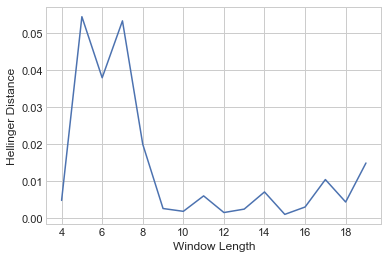

In [39]:
feature_matrix = np.array(feature_matrix)
singular_vec_matrix = np.array(np.array(feature_matrix)) 
#A = get_angle_change(singular_vec_matrix)
D = get_hellinger_distance(feature_matrix)
plt.plot(np.arange(start_idx, X.shape[0]), np.array(D))
plt.xlabel('Window Length')
plt.ylabel('Hellinger Distance')
plt.grid(True)

In [40]:
df_anomaly['Hellinger'] = pd.Series(D, index = np.arange(start_idx, len(df_anomaly.index)))
df_anomaly['Date'] = Date

In [41]:
df_anomaly.head(20)

,Producer,Contaminants,Hellinger,Date
0,38231,3664,NaN,4-Nov
1,37091,1827,NaN,9-Nov
2,40420,110,NaN,15-Nov
3,42040,750,NaN,19-Nov
4,47845,95,0.004875,22-Nov
5,52249,123,0.054530,27-Nov
6,36907,118,0.038025,2-Dec
7,50536,246,0.053406,3-Dec
8,57637,54,0.020053,4-Dec
9,51112,101,0.002679,6-Dec


In [42]:
df_anomaly.columns

Index(['Producer', 'Contaminants', 'Hellinger', 'Date'], dtype='object')

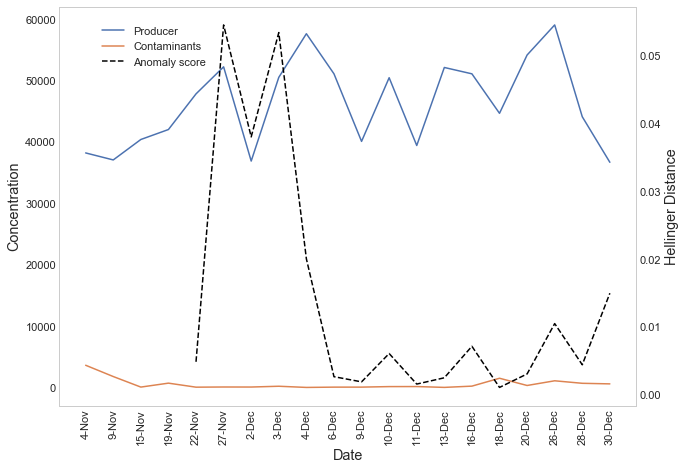

In [45]:
fig, ax1 = plt.subplots()

fig.set_size_inches(10, 7)
ax1.grid(False)

if num_features == '5':
    ax1.plot(Date, df_anomaly['Monoraphidium']) 
    ax1.plot(Date, df_anomaly['Contaminants'])
    ax1.plot(Date, df_anomaly['Producer-Chlorophyceae'])
    ax1.plot(Date, df_anomaly['Producer-Trebouxiophyceae'])
    ax1.plot(Date, df_anomaly['Producer-Other-Streptophyta'])

elif num_features == '3':
    ax1.plot(Date, df_anomaly['Producer']) 
    ax1.plot(Date, df_anomaly['Hydra'])
    ax1.plot(Date, df_anomaly['Fungi'])
    ax1.tick_params(axis ='y') 

elif num_features == '2':
    ax1.plot(Date, df_anomaly['Producer']) 
    ax1.plot(Date, df_anomaly['Contaminants'])
    ax1.tick_params(axis ='y') 

plt.xticks(rotation = 90)

ax1.set_xlabel('Date', size='large')
ax1.set_ylabel('Concentration', size='large')
#plt.legend(df_anomaly.columns)
  
ax2 = ax1.twinx() 
ax2.grid(False)
   
ax2.plot(Date, df_anomaly.Hellinger, color = 'black', linestyle='dashed', label='Anomaly score') 
ax2.tick_params(axis ='y') 

ax2.set_ylabel('Hellinger Distance', size='large')

#fig.legend(bbox_to_anchor=(0.3,0.9))
plt.tight_layout(pad=2)

In [46]:
fig.savefig(pond+'_'+num_features+'.png',dpi=80)